# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

(1 балл)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt

(2 балла)

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

(2 балла)

In [1]:
import os
import hashlib
from base64 import b64encode
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from tqdm import tqdm

In [2]:
def salt_generator() -> str:
    """
    Generates a random salt value.

    Returns:
        str: The base64 encoded salt value as a string.
    """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df: pd.DataFrame, columns: list[str], user_salt: str = None) -> pd.DataFrame:
    """
    Splits the data into two groups based on the salt value.

    Parameters:
        df (pd.DataFrame): The dataframe to split.
        columns (list[str]): The columns to split on.
        salt (str): The salt value to use for the split.
    """
    if user_salt is None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


In [3]:
shop_metrics_new = pd.read_csv('./data_shop/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data_shop/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data_shop/shop_df_users.csv').drop(columns='Unnamed: 0')

In [4]:
print(shop_metrics_new.shape)
shop_metrics_new.head(5)

(222521, 9)


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [5]:
print(shop_metrics_old.shape)
shop_metrics_old.head(5)

(406863, 9)


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


In [6]:
print(shop_users_info.shape)
shop_users_info.head(5)

(407283, 3)


,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


**Метрики:**

 - is_viewed - айтем товара просмотрен
 - products_viewed_cnt - количество уникальных просмотренных айтемов
 - price_sum - суммарная цена товаров
 - is_cart_added - товар добавлен в корзину
 - is_purchased - товар куплен
 - **cart_added_cnt** - количество товаров, добавленных в корзину
 - purchased_cnt - количество купленных товаров

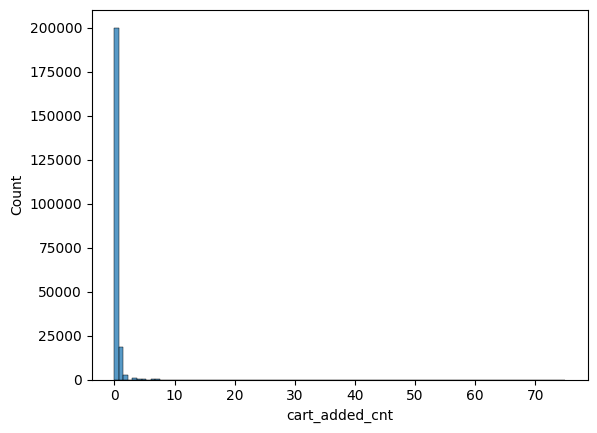

In [7]:
sns.histplot(data=shop_metrics_new, x="cart_added_cnt", bins=100);

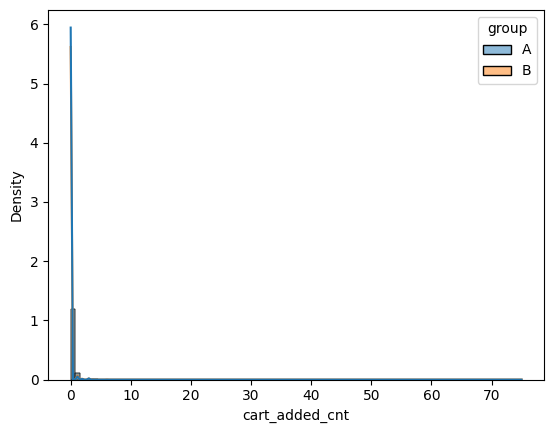

In [8]:
sns.histplot(data=shop_metrics_new, x="cart_added_cnt", hue="group", kde=True, stat="density", common_norm=False, bins=100);

In [9]:
shop_metrics_new.groupby("group")["cart_added_cnt"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


## 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

In [10]:
def rank_transform(df_group_a: pd.DataFrame, df_group_b: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    df = pd.concat([df_group_a, df_group_b], axis=0, ignore_index=True)
    df[f'{metric_name}_rank'] = df[metric_name].rank()
    return df

In [11]:
df_ranked = rank_transform(
    df_group_a=shop_metrics_new[shop_metrics_new["group"] == "A"], 
    df_group_b=shop_metrics_new[shop_metrics_new["group"] == "B"], 
    metric_name='cart_added_cnt'
)

pd.concat([df_ranked.head(), df_ranked.tail()])

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
3,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
4,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5
222520,1515915625611024030,B,1,1,10.16,0.0,0.0,0,0,100038.5


In [12]:
pd.concat([df_ranked[df_ranked["cart_added_cnt"] > 0].head(), df_ranked[df_ranked["cart_added_cnt"] > 0].tail()])

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_rank
7,1515915625353706476,A,1,12,522.75,0.0,0.0,2,0,219885.0
21,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,209349.0
23,1515915625356129712,A,1,4,144.42,0.0,0.0,1,0,209349.0
59,1515915625367976920,A,1,4,144.83,0.0,0.0,1,1,209349.0
62,1515915625368720412,A,1,2,425.56,0.0,0.0,1,0,209349.0
222442,1515915625611002957,B,1,1,490.54,0.0,0.0,1,0,209349.0
222458,1515915625611007170,B,1,1,839.75,0.0,0.0,1,0,209349.0
222473,1515915625611010717,B,1,3,1493.89,0.0,0.0,2,0,219885.0
222477,1515915625611013140,B,1,2,642.29,0.0,0.0,2,0,219885.0
222495,1515915625611017481,B,1,1,214.10,0.0,0.0,1,0,209349.0


In [13]:
print(df_ranked[df_ranked.group == 'A']['cart_added_cnt_rank'].mean(),
      df_ranked[df_ranked.group == 'B']['cart_added_cnt_rank'].mean(), 
      ((df_ranked[df_ranked.group == 'B']['cart_added_cnt_rank'].mean() - df_ranked[df_ranked.group == 'A']['cart_added_cnt_rank'].mean()) / 
       df_ranked[df_ranked.group == 'A']['cart_added_cnt_rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


**Различие в между средними в группах составляет ~0.1629%**

**t-test**

In [14]:
statictic, p_value = stats.ttest_ind(
    df_ranked[df_ranked.group == 'A']['cart_added_cnt_rank'], 
    df_ranked[df_ranked.group == 'B']['cart_added_cnt_rank']
)

print(f"P-value: {p_value}")
if p_value < 0.05:
    print("H0 отклюняется, найдены статитистически значимый отличий")
else:
    print("H0 принимается, не найдены статитистически значимые отличия")

P-value: 0.20253266477504916
H0 принимается, не найдены статитистически значимые отличия


Различий между группами не было => t-test не нашел разнциа

**Манна-Уитни:**

In [15]:
statictic, p_value = stats.mannwhitneyu(
    df_ranked[df_ranked.group == 'A']['cart_added_cnt'], 
    df_ranked[df_ranked.group == 'B']['cart_added_cnt']
)

print(p_value)
if p_value < 0.05:
    print("H0 отклюняется, найдены статитистически значимый отличий")
else:
    print("H0 принимается, не найдены статитистически значимые отличия")

0.2025319893087626
H0 принимается, не найдены статитистически значимые отличия


**Оба подхода не нашли стат. значимых отличий в группах**, так как действительно оно не очень большое ~0.16%

**Проверка мощности и корректности t-test для метода ранговой трансформации:**

In [16]:
df_shop = shop_metrics_new.drop(columns=['group'])
df_shop.head(3)

,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,1,4,179.60,0.0,0.0,0,0


In [17]:
ALPHA = 0.05
ITER = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


p_value = 0.25912322580388847 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 95.600%


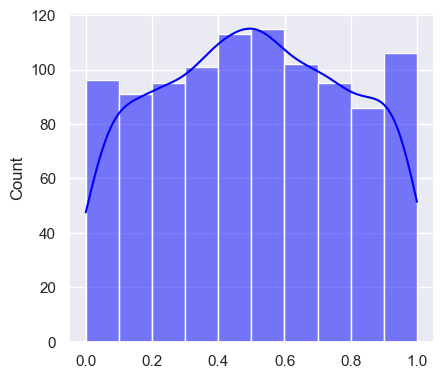

In [18]:
correctness = []
power = []

for idx in tqdm(range(ITER)):

    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    df_ranked_curr = rank_transform(
        df_group_a=df_with_group[df_with_group["group"] == "A"], 
        df_group_b=df_with_group[df_with_group["group"] == "B"], 
        metric_name='cart_added_cnt'
    )

    vec_a = df_ranked_curr[df_ranked_curr.group == 'A']['cart_added_cnt_rank']
    vec_b = df_ranked_curr[df_ranked_curr.group == 'B']['cart_added_cnt_rank']

    vec_b_effect = df_with_group[df_with_group['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = df_with_group[df_with_group.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)
    
    df_ranked_curr_effect = rank_transform(
        df_group_a=df_with_group[df_with_group.group == 'A'], 
        df_group_b=new_df_b, 
        metric_name='cart_added_cnt'
    )
    vec_a_power = df_ranked_curr_effect[df_ranked_curr_effect['group'] == 'A']['cart_added_cnt_rank']
    vec_b_power = df_ranked_curr_effect[df_ranked_curr_effect['group'] == 'B']['cart_added_cnt_rank']


    p_correctness, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_correctness)
    power.append(p_power)


correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

***Мощность и корректность при уровне значимости alpha достаточно хороши***

**Проверка мощности и корректности Манна-Уитни на исходной метрике `cart_added_cnt`:**

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


p_value = 0.9123146326538728 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 95.600%


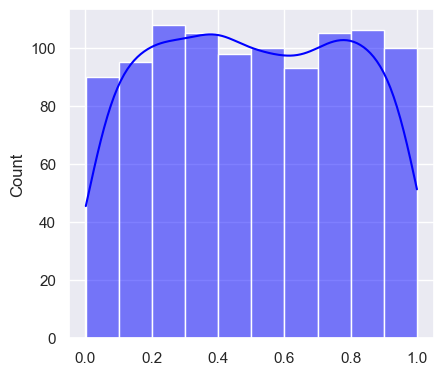

In [19]:
correctness = []
power = []

for idx in tqdm(range(ITER)):

    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    vec_a = df_with_group[df_with_group.group == 'A']['cart_added_cnt']
    vec_b = df_with_group[df_with_group.group == 'B']['cart_added_cnt']
    vec_b_effect = vec_b * 1.05

    p_correctness, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

***Мощность и корректность при уровне значимости alpha достаточно хороши***

**Результаты ранговой трансформации с критерием t-test имеет примерно одинаковый результат с критерием Манна-Уитни на оригинальной метрике `cart_added_cnt`**

## 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

In [20]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m + '_covariate')
        cuped_column = str(m + '_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


In [21]:
ALPHA = 0.05
ITER = 1000

**t-test на обычной метрике + CUPED**

In [22]:
power = []
diff_var_a, diff_var_b = [], []
diff_mean_group_in_cov = []
diff_mean_a, diff_mean_b = [], []


for idx in tqdm(range(ITER)):

    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    all_df = pd.merge(df_with_group, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]
    power.append(p_power)

    var_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].var()
    var_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].var()
    mean_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].mean()
    mean_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].mean()
    mean_a_in_cov = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt_covariate"].mean()
    mean_b_in_cov = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt_covariate"].mean()

    var_cuped_a = vec_a.var()
    var_cuped_b = vec_b_effect.var()
    mean_cuped_a = vec_a.mean()
    mean_cuped_b = vec_b_effect.mean()

    diff_var_a.append(var_a - var_cuped_a)
    diff_var_b.append(var_b - var_cuped_b)
    diff_mean_a.append(abs(mean_a - mean_cuped_a))
    diff_mean_b.append(abs(mean_b - mean_cuped_b))
    diff_mean_group_in_cov.append(abs(mean_a_in_cov - mean_b_in_cov))

power = np.array(power)
power_res1 = len(power[power < ALPHA]) / len(power) 

diff_var_a1 = np.mean(diff_var_a)
diff_var_b1 = np.mean(diff_var_b)
diff_mean_a1 = np.mean(diff_mean_a)
diff_mean_b1 = np.mean(diff_mean_b)
diff_mean_group_in_cov1 = np.mean(diff_mean_group_in_cov)

print(
    f" === Power: {power_res1:.3%}\n"
    f" ============================\n"
    f" === Диспресия в среднем сокращается в группе А на {diff_var_a1:.5}; в группе B на {diff_var_b1:.5}\n"
    f" === Разница средних до и после применения cuped в среднем в группе А: {diff_mean_a1:.5}; в группе B: {diff_mean_b1:.5}\n"
    f" === Разница средних в коварите между группами А и B в среднем: {diff_mean_group_in_cov1:.5}\n"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:23<00:00,  2.25it/s]

 === Power: 100.000%
 === Диспресия в среднем сокращается в группе А на 0.38065; в группе B на 0.38288
 === Разница средних до и после применения cuped в среднем в группе А: 0.0010523; в группе B: 0.0067887
 === Разница средних в коварите между группами А и B в среднем: 0.002251



**логарфимированной метрике cart_added_cnt + CUPED:**

In [23]:
power = []
diff_var_a, diff_var_b = [], []
diff_mean_group_in_cov = []
diff_mean_a, diff_mean_b = [], []


for idx in tqdm(range(ITER)):

    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    all_df = pd.merge(df_with_group, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
     # Прологарифмируем метрики в группах
    all_df["cart_added_cnt"] = np.log(all_df["cart_added_cnt"] + 1)
    all_df["cart_added_cnt_covariate"] = np.log(all_df["cart_added_cnt_covariate"] + 1)

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]
    power.append(p_power)

    var_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].var()
    var_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].var()
    mean_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].mean()
    mean_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].mean()
    mean_a_in_cov = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt_covariate"].mean()
    mean_b_in_cov = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt_covariate"].mean()

    var_cuped_a = vec_a.var()
    var_cuped_b = vec_b_effect.var()
    mean_cuped_a = vec_a.mean()
    mean_cuped_b = vec_b_effect.mean()

    diff_var_a.append(var_a - var_cuped_a)
    diff_var_b.append(var_b - var_cuped_b)
    diff_mean_a.append(abs(mean_a - mean_cuped_a))
    diff_mean_b.append(abs(mean_b - mean_cuped_b))
    diff_mean_group_in_cov.append(abs(mean_a_in_cov - mean_b_in_cov))


power = np.array(power)
power_res2 = len(power[power < ALPHA]) / len(power) 

diff_var_a2 = np.mean(diff_var_a)
diff_var_b2 = np.mean(diff_var_b)
diff_mean_a2 = np.mean(diff_mean_a)
diff_mean_b2 = np.mean(diff_mean_b)
diff_mean_group_in_cov2 = np.mean(diff_mean_group_in_cov)

print(
    f" === Power: {power_res2:.3%}\n"
    f" ============================\n"
    f" === Диспресия в среднем сокращается в группе А на {diff_var_a2:.5}; в группе B на {diff_var_b2:.5}\n"
    f" === Разница средних до и после применения cuped в среднем в группе А: {diff_mean_a2:.5}; в группе B: {diff_mean_b2:.5}\n"
    f" === Разница средних в коварите между группами А и B в среднем: {diff_mean_group_in_cov2:.5}\n"
)

100%|██████████| 1000/1000 [07:27<00:00,  2.24it/s]

 === Power: 100.000%
 === Диспресия в среднем сокращается в группе А на 0.063575; в группе B на 0.063362
 === Разница средних до и после применения cuped в среднем в группе А: 0.0004221; в группе B: 0.0040238
 === Разница средних в коварите между группами А и B в среднем: 0.00087337



**CUPED метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)**

In [24]:
power = []
diff_var_a, diff_var_b = [], []
diff_mean_group_in_cov = []
diff_mean_a, diff_mean_b = [], []


for idx in tqdm(range(ITER)):

    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    all_df = pd.merge(df_with_group, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    # CUPED transform
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    # Added effect 5%
    cuped_df.loc[cuped_df.group == 'B', 'cart_added_cnt_cuped'] *= 1.05

    # RANK transform
    df_cuped_ranked_curr = rank_transform(
        df_group_a=cuped_df[cuped_df["group"] == "A"], 
        df_group_b=cuped_df[cuped_df["group"] == "B"], 
        metric_name='cart_added_cnt_cuped'
    )

    vec_a_rank = df_cuped_ranked_curr[df_cuped_ranked_curr['group'] == 'A']['cart_added_cnt_cuped_rank']
    vec_b_rank_effect = df_cuped_ranked_curr[df_cuped_ranked_curr['group'] == 'B']['cart_added_cnt_cuped_rank']

    p_power = stats.ttest_ind(vec_a_rank, vec_b_rank_effect)[1]
    power.append(p_power)

    var_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].var()
    var_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].var()
    mean_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt"].mean()
    mean_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt"].mean()
    mean_a_in_cov = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt_covariate"].mean()
    mean_b_in_cov = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt_covariate"].mean()

    var_cuped_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt_cuped"].var()
    var_cuped_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt_cuped"].var()
    mean_cuped_a = cuped_df[(cuped_df['group'] == 'A')]["cart_added_cnt_cuped"].mean()
    mean_cuped_b = cuped_df[(cuped_df['group'] == 'B')]["cart_added_cnt_cuped"].mean()

    diff_var_a.append(var_a - var_cuped_a)
    diff_var_b.append(var_b - var_cuped_b)
    diff_mean_a.append(abs(mean_a - mean_cuped_a))
    diff_mean_b.append(abs(mean_b - mean_cuped_b))
    diff_mean_group_in_cov.append(abs(mean_a_in_cov - mean_b_in_cov))

power = np.array(power)
power_res3 = len(power[power < ALPHA]) / len(power) 

diff_var_a3 = np.mean(diff_var_a)
diff_var_b3 = np.mean(diff_var_b)
diff_mean_a3 = np.mean(diff_mean_a)
diff_mean_b3 = np.mean(diff_mean_b)
diff_mean_group_in_cov3 = np.mean(diff_mean_group_in_cov)

print(
    f" === Power: {power_res3:.3%}\n"
    f" ============================\n"
    f" === Диспресия в среднем сокращается в группе А на {diff_var_a3:.5}; в группе B на {diff_var_b3:.5}\n"
    f" === Разница средних до и после применения cuped в среднем в группе А: {diff_mean_a3:.5}; в группе B: {diff_mean_b3:.5}\n"
    f" === Разница средних в коварите между группами А и B в среднем: {diff_mean_group_in_cov3:.5}\n"
)

100%|██████████| 1000/1000 [08:40<00:00,  1.92it/s]

 === Power: 100.000%
 === Диспресия в среднем сокращается в группе А на 0.38502; в группе B на 0.37851
 === Разница средних до и после применения cuped в среднем в группе А: 0.0010671; в группе B: 0.0068689
 === Разница средних в коварите между группами А и B в среднем: 0.0022822



In [25]:
df_result = pd.DataFrame(
    {
        "power": [power_res1, power_res2, power_res3],
        "Сокращение дисперсии в группе А": [diff_var_a1, diff_var_a2, diff_var_a3],
        "Сокращение дисперсии в группе B": [diff_var_b1, diff_var_b2, diff_var_b3],
        "Разница средних в группе А": [diff_mean_a1, diff_mean_a2, diff_mean_a3],
        "Разница средних в группе Б": [diff_mean_b1, diff_mean_b2, diff_mean_b3],
        "Разница средних в ковариате между группами А и Б": [diff_mean_group_in_cov1, diff_mean_group_in_cov2, diff_mean_group_in_cov3],
    },
    index=["cart_added_cnt+CUPED", "cart_added_cnt+log+CUPED", "cart_added_cnt+CUPED+RANK"]
)

df_result

,power,Сокращение дисперсии в группе А,Сокращение дисперсии в группе B,Разница средних в группе А,Разница средних в группе Б,Разница средних в ковариате между группами А и Б
cart_added_cnt+CUPED,1.0,0.380646,0.382882,0.001052,0.006789,0.002251
cart_added_cnt+log+CUPED,1.0,0.063575,0.063362,0.000422,0.004024,0.000873
cart_added_cnt+CUPED+RANK,1.0,0.385025,0.378508,0.001067,0.006869,0.002282


**Все подходы демонстрируют хорошую мощность.** Возможно следевало бы взять во внимание распределение метрики и добавлять эффект с учетом этого, а не просто домножать на константу

## 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt

In [26]:
def get_bucket(df: pd.DataFrame, col_metric: str, num_buckets: int) -> pd.DataFrame:
    df = (
        df.sort_values(by=col_metric)
        .reset_index(drop=True)
    )
    bucket_size = len(df) // num_buckets   
    df["bucket"] =  df.index // bucket_size

    df = df.groupby("bucket", as_index=False)[col_metric].agg("mean")
    df.rename(columns={"bucket": "user_id"}, inplace=True)
    
    return df

**на логнормальном распределении (сгенерированные данные):**

In [27]:
size = 1_000_000
log_norm_data = np.random.lognormal(mean=0, sigma=1, size=size)
df_log_norm = pd.DataFrame({"user_id": np.arange(size), "metric": log_norm_data})
df_log_norm.head()

,user_id,metric
0,0,0.697330
1,1,1.751290
2,2,2.615818
3,3,0.305159
4,4,2.706582


In [28]:
ALPHA = 0.5
ITER = 1000
NUM_BUCKETS = [100, 1_000, 10_000, 50_000, 100_000, 500_000]

**без бакитирования:**

100%|██████████| 1000/1000 [24:03<00:00,  1.44s/it]


p_value = 0.11623996612206355 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 50.900%


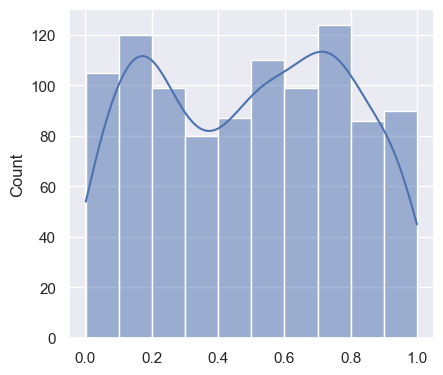

In [29]:
correctness = []
power = []

for idx in tqdm(range(ITER)):
    df_with_group = groups_splitter(df_log_norm.copy(), columns=["user_id", "group", "metric"], user_salt=salt_generator())

    vec_a = df_with_group[df_with_group.group == 'A']['metric']
    vec_b = df_with_group[df_with_group.group == 'B']['metric']
    vec_b_effect = vec_b * 1.05

    p_correctness, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.histplot(data=correctness, bins=10, kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

**Мощность хорошая, но корректность не очень, хоть она и имеет равномерное распредление по критерию Колмоговора-Смирнова**

**с бакитированием:**

 === Number of buckets: 100 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 100.000%
 === Correctness: 50.900%


100%|██████████| 1000/1000 [00:02<00:00, 344.34it/s]


p_value = 0.025812033493359587 - p_values неравномерное распределение
 === Power: 54.400%
 === Correctness: 47.600%

****************************************

 === Number of buckets: 1000 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 54.400%
 === Correctness: 47.600%


100%|██████████| 1000/1000 [00:03<00:00, 333.33it/s]


p_value = 0.5163363840624504 - p_values равномерное распределение
 === Power: 56.900%
 === Correctness: 50.000%

****************************************

 === Number of buckets: 10000 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 56.900%
 === Correctness: 50.000%


100%|██████████| 1000/1000 [00:16<00:00, 60.18it/s]


p_value = 0.7448380799961092 - p_values равномерное распределение
 === Power: 88.400%
 === Correctness: 49.500%

****************************************

 === Number of buckets: 50000 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 88.400%
 === Correctness: 49.500%


100%|██████████| 1000/1000 [01:17<00:00, 12.86it/s]


p_value = 0.1991259123095157 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 52.800%

****************************************

 === Number of buckets: 100000 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 100.000%
 === Correctness: 52.800%


100%|██████████| 1000/1000 [02:28<00:00,  6.75it/s]


p_value = 0.3521674368262536 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 51.200%

****************************************

 === Number of buckets: 500000 ===
p_value = 0.0 - распределние мерики после бакитирования не нормальное
 === Power: 100.000%
 === Correctness: 51.200%


100%|██████████| 1000/1000 [1:20:12<00:00,  4.81s/it] 


p_value = 0.9072779722936823 - p_values равномерное распределение
 === Power: 100.000%
 === Correctness: 49.900%

****************************************



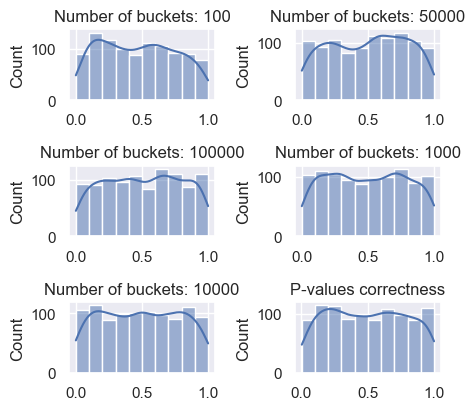

In [30]:
correctnesses, powers, norms = [], [], []

fig, axs = plt.subplots(3, 2)
for plt_idx, n_bucket in enumerate(NUM_BUCKETS):
    print(f" === Number of buckets: {n_bucket} ===")
    df_log_norm_bucket = get_bucket(df=df_log_norm.copy(), col_metric="metric", num_buckets=n_bucket)

    _, p_value_for_norm = stats.kstest(correctness, 
                                       scipy.stats.norm(loc=df_log_norm_bucket['metric'].mean(), 
                                                        scale=df_log_norm_bucket['metric'].std()).cdf)
    if p_value_for_norm < 0.05:
        print(f'p_value = {p_value_for_norm} - распределние мерики после бакитирования не нормальное')
        norms.append(False)
    else:
        norms.append(True)
        print(f'p_value = {p_value_for_norm} - распределние мерики после бакитирования нормальное')

    print(
        f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
        f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
    )
    correctness = []
    power = []

    for idx in tqdm(range(ITER)):
        df_with_group = groups_splitter(df_log_norm_bucket.copy(), columns=["user_id", "group", "metric"], user_salt=salt_generator())

        vec_a = df_with_group[df_with_group.group == 'A']['metric']
        vec_b = df_with_group[df_with_group.group == 'B']['metric']
        vec_b_effect = vec_b * 1.05

        p_correctness, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        correctness.append(p_correctness)
        power.append(p_power)

    correctness = np.array(correctness)
    power = np.array(power)

    sns.histplot(data=correctness, bins=10, kde=True, ax=axs[plt_idx % 3, plt_idx % 2]) 
    axs[plt_idx % 3, plt_idx % 2].set_title(f"Number of buckets: {n_bucket}")

    _, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
    if p_value_for_norm < 0.05:
        print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

    print(
        f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
        f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
    )

    correctnesses.append(np.round((1 - len(correctness[correctness < ALPHA]) / len(correctness)) * 100, 3))
    powers.append(np.round(len(power[power < ALPHA]) / len(power) * 100, 3))

    print("\n****************************************\n")

plt.title("P-values correctness")
plt.tight_layout()

In [31]:
pd.DataFrame(
    {
        "Number of buckets": NUM_BUCKETS,
        "Power": powers,
        "Correctness": correctnesses,
        "Dist_normal": norms,
    }
)

,Number of buckets,Power,Correctness,Dist_normal
0,100,54.4,47.6,False
1,1000,56.9,50.0,False
2,10000,88.4,49.5,False
3,50000,100.0,52.8,False
4,100000,100.0,51.2,False
5,500000,100.0,49.9,False


**При увеличении кол-во бакетов мощность растет (Я это связываю с тем, что эффект следовало бы добавлять по-другому так как тут логнормальное распределение), но корректность теста покзаывает низкие результаты, колеблясь в диапазоне от 47 дл 51**

**на метрике cart_added_cnt:**

**без бакитирования:**

100%|██████████| 1000/1000 [3:15:10<00:00, 11.71s/it]   


p_value = 0.6968397633081778 - p_values равномерное распределение
 === Power: 94.800%
 === Correctness: 49.300%


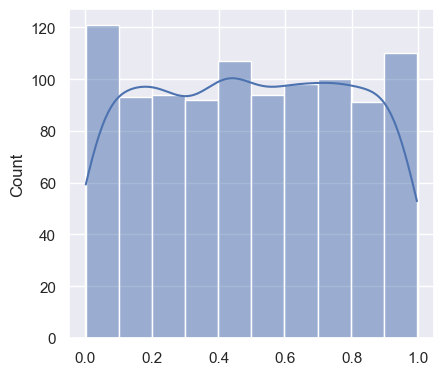

In [32]:
correctness = []
power = []

for idx in tqdm(range(ITER)):
    df_with_group = groups_splitter(df_shop.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

    vec_a = df_with_group[df_with_group.group == 'A']['cart_added_cnt']
    vec_b = df_with_group[df_with_group.group == 'B']['cart_added_cnt']
    vec_b_effect = vec_b * 1.05

    p_correctness, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.histplot(data=correctness, bins=10, kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

**Мощность хорошая, но корректность не очень, хоть она и имеет равномерное распредление по критерию Колмоговора-Смирнова**

**c бакитированием:**

In [33]:
NUM_BUCKETS = [100, 1_000, 10_000, 25_000, 50_000, 100_000]

 === Number of buckets: 100 ===
p_value = 6.16529004645696e-181 - распределние мерики после бакитирования не нормальное
 === Power: 94.800%
 === Correctness: 49.300%


100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


p_value = 8.791558490374316e-199 - p_values неравномерное распределение
 === Power: 95.900%
 === Correctness: 3.700%

*****************************************************

 === Number of buckets: 1000 ===
p_value = 6.615856490280428e-231 - распределние мерики после бакитирования не нормальное
 === Power: 95.900%
 === Correctness: 3.700%


100%|██████████| 1000/1000 [00:03<00:00, 318.04it/s]


p_value = 1.0576452821396001e-08 - p_values неравномерное распределение
 === Power: 58.500%
 === Correctness: 40.800%

*****************************************************

 === Number of buckets: 10000 ===
p_value = 9.271404425656619e-169 - распределние мерики после бакитирования не нормальное
 === Power: 58.500%
 === Correctness: 40.800%


100%|██████████| 1000/1000 [12:22<00:00,  1.35it/s] 


p_value = 0.06852147819628485 - p_values неравномерное распределение
 === Power: 55.500%
 === Correctness: 47.200%

*****************************************************

 === Number of buckets: 25000 ===
p_value = 1.1247851328461433e-167 - распределние мерики после бакитирования не нормальное
 === Power: 55.500%
 === Correctness: 47.200%


100%|██████████| 1000/1000 [30:23<00:00,  1.82s/it] 


p_value = 0.1770741758338068 - p_values неравномерное распределение
 === Power: 62.700%
 === Correctness: 48.900%

*****************************************************

 === Number of buckets: 50000 ===
p_value = 3.867820415293586e-163 - распределние мерики после бакитирования не нормальное
 === Power: 62.700%
 === Correctness: 48.900%


100%|██████████| 1000/1000 [1:05:08<00:00,  3.91s/it]  


p_value = 0.5302988915356598 - p_values неравномерное распределение
 === Power: 71.400%
 === Correctness: 48.900%

*****************************************************

 === Number of buckets: 100000 ===
p_value = 2.1286568159916456e-158 - распределние мерики после бакитирования не нормальное
 === Power: 71.400%
 === Correctness: 48.900%


100%|██████████| 1000/1000 [12:43:56<00:00, 45.84s/it]       


p_value = 0.6061230001485907 - p_values неравномерное распределение
 === Power: 84.600%
 === Correctness: 49.100%

*****************************************************



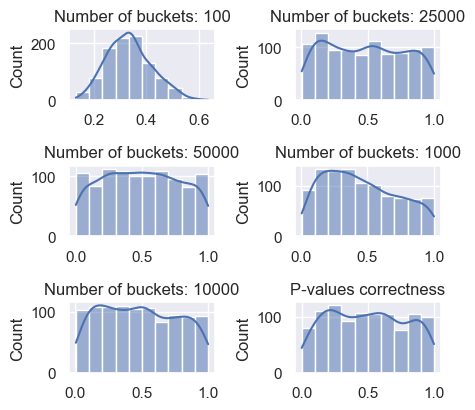

In [34]:
correctnesses, powers, normals = [], [], []

fig, axs = plt.subplots(3, 2)
for plt_idx, n_bucket in enumerate(NUM_BUCKETS):
    print(f" === Number of buckets: {n_bucket} ===")
    df_shop_bucket = get_bucket(df=df_shop.copy(), col_metric="cart_added_cnt", num_buckets=n_bucket)

    _, p_value_for_norm = stats.kstest(correctness, 
                                       scipy.stats.norm(loc=df_shop_bucket['cart_added_cnt'].mean(), 
                                                        scale=df_shop_bucket['cart_added_cnt'].std()).cdf)
    if p_value_for_norm < 0.05:
        print(f'p_value = {p_value_for_norm} - распределние мерики после бакитирования не нормальное')
        normals.append(False)
    else:
        normals.append(True)
        print(f'p_value = {p_value_for_norm} - распределние мерики после бакитирования нормальное')

    print(
        f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
        f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
    )

    correctness = []
    power = []

    for idx in tqdm(range(ITER)):

        df_with_group = groups_splitter(df_shop_bucket.copy(), columns=["user_id", "group", "cart_added_cnt"], user_salt=salt_generator())

        vec_a = df_with_group[df_with_group.group == 'A']['cart_added_cnt']
        vec_b = df_with_group[df_with_group.group == 'B']['cart_added_cnt']
        vec_b_effect = vec_b * 1.05

        p_correctness, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        correctness.append(p_correctness)
        power.append(p_power)

    correctness = np.array(correctness)
    power = np.array(power)

    sns.histplot(data=correctness, bins=10, kde=True, ax=axs[plt_idx % 3, plt_idx % 2]) 
    axs[plt_idx % 3, plt_idx % 2].set_title(f"Number of buckets: {n_bucket}")

    _, p_value_for_uninorm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
    if p_value_for_norm < 0.05:
        print(f'p_value = {p_value_for_uninorm} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value_for_uninorm} - p_values равномерное распределение')

    print(
        f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
        f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
    )

    correctnesses.append(np.round(len(power[power < ALPHA]) / len(power) * 100, 3))
    powers.append(np.round((1 - len(correctness[correctness < ALPHA]) / len(correctness)) * 100, 3))

    print("\n*****************************************************\n")

plt.title("P-values correctness")
plt.tight_layout()

In [35]:
pd.DataFrame(
    {
        "Number of buckets": NUM_BUCKETS,
        "Power": powers,
        "Correctness": correctnesses,
        "Dist_Normal": norms,
    }
)

,Number of buckets,Power,Correctness,Dist_Normal
0,100,3.7,95.9,False
1,1000,40.8,58.5,False
2,10000,47.2,55.5,False
3,25000,48.9,62.7,False
4,50000,48.9,71.4,False
5,100000,49.1,84.6,False


**Уже наблюдается другая картина (по сравнению со сгенирированными данными), мощность растет, но не значительно при увелически кол-ва бакетов, а корректность наоборот уменьшается**

# 4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

In [36]:
df_shop_old = shop_metrics_old.copy()  #.drop("group", axis=1)
pd.concat([df_shop_old.head(), df_shop_old.tail()])

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0
406858,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0
406859,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0
406860,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0
406861,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0
406862,1515915625611024030,B,1,1,10.16,0.0,0.0,0,0


In [37]:
shop_users_info.head()

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [38]:
shop_users_info.isnull().sum()

user_id     0
user_age    0
user_sex    0
dtype: int64

In [39]:
shop_users_info["user_sex"].value_counts()

user_sex
m    244365
f    162918
Name: count, dtype: int64

In [40]:
df_shop_old_w_features = pd.merge(df_shop_old[["user_id", "group", "cart_added_cnt"]], shop_users_info, on=['user_id'], how='left')
df_shop_old_w_features.head()

,user_id,group,cart_added_cnt,user_age,user_sex
0,1515915625353226922,B,0,55,f
1,1515915625353230067,A,0,58,m
2,1515915625353230683,A,0,23,f
3,1515915625353230922,A,0,33,m
4,1515915625353234047,A,0,26,f


In [41]:
df_shop_old_w_features.isnull().sum()

user_id           0
group             0
cart_added_cnt    0
user_age          0
user_sex          0
dtype: int64

In [42]:
df_shop_old_w_features.user_age.min(), df_shop_old_w_features.user_age.max()

(18, 84)

In [43]:
df_shop_old_w_features["age_group"] = (
    df_shop_old_w_features["user_age"].mask(
        (df_shop_old_w_features["user_age"] >= 18) & (df_shop_old_w_features["user_age"] <= 24), "18-24"
    ).mask(
        (df_shop_old_w_features["user_age"] >= 25) & (df_shop_old_w_features["user_age"] <= 45), "25-45"
    ).mask(
        (df_shop_old_w_features["user_age"] >= 46) & (df_shop_old_w_features["user_age"] <= 60), "46-60"
    ).mask(
        (df_shop_old_w_features["user_age"] >= 61) & (df_shop_old_w_features["user_age"] <= 75), "61-75"
    ).mask(
        df_shop_old_w_features["user_age"] >= 76, "76+"
    )   
)

display(df_shop_old_w_features["age_group"].value_counts())
df_shop_old_w_features.head()

age_group
25-45    127901
46-60     91051
61-75     90435
76+       54818
18-24     42658
Name: count, dtype: int64

,user_id,group,cart_added_cnt,user_age,user_sex,age_group
0,1515915625353226922,B,0,55,f,46-60
1,1515915625353230067,A,0,58,m,46-60
2,1515915625353230683,A,0,23,f,18-24
3,1515915625353230922,A,0,33,m,25-45
4,1515915625353234047,A,0,26,f,25-45


In [44]:
df_shop_old_w_features.groupby(["user_sex", "age_group"])["user_id"].count()

user_sex  age_group
f         18-24        16952
          25-45        50979
          46-60        36447
          61-75        36185
          76+          22207
m         18-24        25706
          25-45        76922
          46-60        54604
          61-75        54250
          76+          32611
Name: user_id, dtype: int64

In [45]:
df_shop_old_w_features["sex_age_group"] = df_shop_old_w_features["user_sex"] + "_" + df_shop_old_w_features["age_group"]

**Без постратификации:**

In [46]:
_, p_value = stats.ttest_ind(
    df_shop_old_w_features[df_shop_old_w_features.group == 'A']['cart_added_cnt'], 
    df_shop_old_w_features[df_shop_old_w_features.group == 'B']['cart_added_cnt']
)

if p_value < 0.05:
    print(f'p_value = {p_value} - есть значимые отличия в группах.')
else:
    print(f'p_value = {p_value} - нет значимых отличий в группах.')

p_value = 0.4634447828246868 - нет значимых отличий в группах.


**Отличие средних в группах:**

In [47]:
diff_mean = (
    (
        df_shop_old_w_features[df_shop_old_w_features.group == 'B']["cart_added_cnt"].mean() 
        - df_shop_old_w_features[df_shop_old_w_features.group == 'A']["cart_added_cnt"].mean()
    ) / df_shop_old_w_features[df_shop_old_w_features.group == 'A']["cart_added_cnt"].mean()
) 

print(f"В группе Б среднее больше на {diff_mean:.3%}")

В группе Б среднее больше на 1.124%


In [48]:
print(df_shop_old_w_features[df_shop_old_w_features.group == 'A']['cart_added_cnt'].std(), 
      df_shop_old_w_features[df_shop_old_w_features.group == 'B']['cart_added_cnt'].std())

0.576689119780438 0.5987645651973791


**C постратификацией:**

In [49]:
df_shop_old_w_features.groupby("group")["sex_age_group"].value_counts()

group  sex_age_group
A      m_25-45          38432
       m_46-60          27321
       m_61-75          27001
       f_25-45          25540
       f_46-60          18336
       f_61-75          17939
       m_76+            16249
       m_18-24          12890
       f_76+            11125
       f_18-24           8503
B      m_25-45          38490
       m_46-60          27283
       m_61-75          27249
       f_25-45          25439
       f_61-75          18246
       f_46-60          18111
       m_76+            16362
       m_18-24          12816
       f_76+            11082
       f_18-24           8449
Name: count, dtype: int64

In [51]:
N = df_shop_old_w_features['user_id'].nunique()

mean_a, mean_b = 0, 0
std_a, std_b = 0, 0
for idx in range(0, df_shop_old_w_features["sex_age_group"].nunique()):
    key = df_shop_old_w_features['sex_age_group'].value_counts().index[idx]
    strats_weights = df_shop_old_w_features['sex_age_group'].value_counts().iloc[idx] / N

    mean_a += df_shop_old_w_features[
        (df_shop_old_w_features.group == 'A')
        & (df_shop_old_w_features['sex_age_group'] == key)
    ]['cart_added_cnt'].mean() * strats_weights

    mean_b += df_shop_old_w_features[
        (df_shop_old_w_features.group == 'B')
        & (df_shop_old_w_features['sex_age_group'] == key)
    ]['cart_added_cnt'].mean() * strats_weights

    std_a += df_shop_old_w_features[
        (df_shop_old_w_features.group == 'A')
        & (df_shop_old_w_features['sex_age_group'] == key)
    ]['cart_added_cnt'].std()**2 * strats_weights

    std_b += df_shop_old_w_features[
        (df_shop_old_w_features.group == 'B')
        & (df_shop_old_w_features['sex_age_group'] == key)
    ]['cart_added_cnt'].std()**2 * strats_weights

std_a /= N
std_b /= N

n_a = len(df_shop_old_w_features[df_shop_old_w_features.group == 'A'])
n_b = len(df_shop_old_w_features[df_shop_old_w_features.group == 'B'])

print(f'effect: {(mean_b - mean_a)/mean_a:.3%}, std_a: {std_a}, std_b: {std_b}')

statistic, p_value = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)
if p_value < 0.05:
    print(f'p_value = {p_value} - есть значимые отличия в группах.')
else:
    print(f'p_value = {p_value} - нет значимых отличий в группах.')

effect: 1.124%, std_a: 8.179175411681481e-07, std_b: 8.814427810322829e-07
p_value = 0.0 - есть значимые отличия в группах.


**Подход с постратификацией показывает, что значимые отличия в группах есть, скорее всего из-за того, в какой-то из групп эффект есть**

**проверить мощность и корректность t-критерия для постстратифицированного случая**

In [52]:
df_shop_old_w_features.drop("group", axis=1, inplace=True)

In [53]:
ALPHA = 0.5
ITER = 1000

**Вариант 1: сплитуем на группы, а потом считаем метрики в каждой из групп**

100%|██████████| 1000/1000 [24:03<00:00,  1.44s/it]


p_value = 0.0 - p_values неравномерное распределение
 === Power: 100.000%
 === Correctness: 0.000%


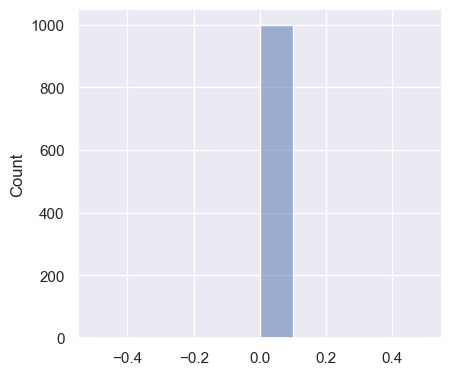

In [54]:
correctness = []
power = []

for idx in tqdm(range(ITER)):
    df_with_group = groups_splitter(df_shop_old_w_features.copy(), 
                                    columns=["user_id", "group", "sex_age_group", "cart_added_cnt"], 
                                    user_salt=salt_generator())

    vec_a = df_with_group[(df_with_group.group == 'A')][["sex_age_group", "cart_added_cnt"]]
    vec_b = df_with_group[(df_with_group.group == 'B')][["sex_age_group", "cart_added_cnt"]]
    vec_b_effect = vec_b.copy()
    vec_b_effect["cart_added_cnt"] *= 1.05
    
    N = df_with_group['user_id'].nunique()
    
    mean_a, mean_b, mean_b_effect = 0, 0, 0
    std_a, std_b, std_b_effect = 0, 0, 0
    for idx in range(0, df_with_group["sex_age_group"].nunique()):
        key = df_with_group['sex_age_group'].value_counts().index[idx]
        strats_weights = df_with_group['sex_age_group'].value_counts().iloc[idx] / N

        mean_a += vec_a[(vec_a['sex_age_group'] == key)]['cart_added_cnt'].mean() * strats_weights
        mean_b += vec_b[(vec_b['sex_age_group'] == key)]['cart_added_cnt'].mean() * strats_weights
        mean_b_effect += vec_b_effect[(vec_b_effect['sex_age_group'] == key)]['cart_added_cnt'].mean() * strats_weights

        std_a += vec_a[(vec_a['sex_age_group'] == key)]['cart_added_cnt'].std() ** 2 * strats_weights
        std_b += vec_b[(vec_b['sex_age_group'] == key)]['cart_added_cnt'].std() ** 2 * strats_weights
        std_b_effect += vec_b_effect[(vec_b_effect['sex_age_group'] == key)]['cart_added_cnt'].std() ** 2 * strats_weights

    std_a /= N
    std_b /= N
    std_b_effect /= N

    n_a = len(df_with_group[df_with_group.group == 'A'])
    n_b = len(df_with_group[df_with_group.group == 'B'])

    p_correctness = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]
    p_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_effect, std_b_effect, n_b)[1]

    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.histplot(data=correctness, bins=10, kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

**Вариант 2: сплитуем на группы, добавляем эффект внутри каждой группы, считаем метрики внутри групп** (в принципе не отличается от первого варината, но решил проверить)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [13:47<00:00,  1.21it/s]

p_value = 0.0 - p_values неравномерное распределение
 === Power: 100.000%
 === Correctness: 0.000%


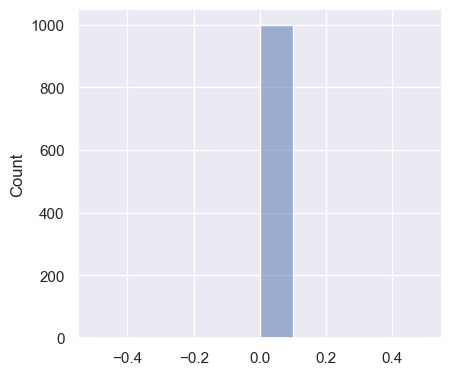

In [55]:
correctness = []
power = []

for idx in tqdm(range(ITER)):
    vecs_a = {}
    vecs_b = {}
    vecs_b_effect = {}
    unique_user_id = []
    strats_weights = {}
    for sag in df_shop_old_w_features["sex_age_group"].unique(): 
        df_with_group = groups_splitter(
            df_shop_old_w_features[df_shop_old_w_features["sex_age_group"] == sag].copy(), 
            columns=["user_id", "group", "cart_added_cnt"], 
            user_salt=salt_generator()
        )

        unique_user_id.extend(df_with_group['user_id'].unique().tolist())
        strats_weights[sag] = len(df_with_group)

        vecs_a[sag] = df_with_group[(df_with_group.group == 'A')]['cart_added_cnt']
        vecs_b[sag] = df_with_group[(df_with_group.group == 'B')]['cart_added_cnt']
        vecs_b_effect[sag] = vecs_b[sag] * 1.05
    
    N = len(set(unique_user_id))
    mean_a, mean_b, mean_b_effect = 0, 0, 0
    std_a, std_b, std_b_effect = 0, 0, 0
    for sag in df_shop_old_w_features["sex_age_group"].unique(): 
        strats_weights[sag] /= N

        mean_a += vecs_a[sag].mean() * strats_weights[sag]
        mean_b += vecs_b[sag].mean() * strats_weights[sag]
        mean_b_effect += vecs_b_effect[sag].mean() * strats_weights[sag]

        std_a += vecs_a[sag].std() ** 2 * strats_weights[sag]
        std_b += vecs_b[sag].std() ** 2 * strats_weights[sag]
        std_b_effect += vecs_b_effect[sag].std() ** 2 * strats_weights[sag]

    std_a /= N
    std_b /= N
    std_b_effect /= N

    n_a = np.sum([len(vec_a) for vec_a in vecs_a.values()])
    n_b = np.sum([len(vec_b) for vec_b in vecs_b.values()])

    p_correctness = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]
    p_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_effect, std_b_effect, n_b)[1]

    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.histplot(data=correctness, bins=10, kde=True)

_, p_value_for_norm = stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value_for_norm < 0.05:
    print(f'p_value = {p_value_for_norm} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_for_norm} - p_values равномерное распределение')

print(
    f" === Power: {len(power[power < ALPHA]) / len(power) :.3%}\n"
    f" === Correctness: {1 - len(correctness[correctness < ALPHA]) / len(correctness):.3%}"
)

**Мощность высокая, корректность очень плохая**